`Objectif du projet :` 

Le projet vise à modéliser et prédire le score Nutri-Score numérique (nutrition-score-fr_100g) des produits alimentaires (tâche de Régression), en utilisant les nutriments principaux comme caractéristiques.

`Source du Dataset :`

Le jeu de données est une extraction de la base de données Open Food Facts (via Open Nutrition App), une base de données collaborative de produits alimentaires du monde entier.

`Jeu de données utilisé :` 

Un échantillon des 100 000 premières lignes est chargé en local pour respecter les contraintes de mémoire et faciliter le prototypage rapide (Dataset Petite/Moyenne taille).

In [1]:
# Importations des librairies Python essentielles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modules Scikit-Learn pour la suite du projet
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 

# Fixer la graine aléatoire pour la reproductibilité
np.random.seed(42)

In [8]:
# --- Configuration du Fichier Local ---
LOCAL_FILE_PATH = 'en.openfoodfacts.org.products.tsv' 
TARGET_COLUMN = 'nutrition-score-fr_100g' # Cible : Score numérique du Nutri-Score (Régression)

# --- Définition des Colonnes Pertinentes (Basée sur l'EDA initiale) ---
# Caractéristiques numériques (Nutriments clés)
numerical_features = [ 
    'energy_100g', 'fat_100g', 'saturated-fat_100g', 
    'sugars_100g', 'salt_100g', 'proteins_100g', 
    'fiber_100g', 'sodium_100g', 'carbohydrates_100g',
    'fruits-vegetables-nuts_100g', 
]

# Caractéristiques catégorielles (Descriptives)
categorical_features = [
    'main_category_en', 
    'brands', 
    'countries_en'
]

# Combinaison pour la sélection
columns_to_keep_final = [TARGET_COLUMN] + numerical_features + categorical_features

# --- Code de Chargement et de Sélection ---
try:
    # Lecture sélective des 100 000 premières lignes (Module 02: Scope)
    off_data = pd.read_csv(
        LOCAL_FILE_PATH, 
        sep='\t',            # Utiliser la tabulation (TSV)
        low_memory=False,
        nrows=100000,        
        index_col=0,         
        encoding='utf-8',
    )
    print(f"✅ Échantillon de données chargé avec succès : {len(off_data)} lignes.")

    # 1. Filtration sur les colonnes sélectionnées
    data = off_data[columns_to_keep_final].copy()
    print(f"✅ DataFrame réduite à {len(data.columns)} colonnes pertinentes.")

    # 2. Nettoyage de la Cible (Étape la plus critique pour l'entraînement supervisé)
    initial_rows = len(data)
    data.dropna(subset=[TARGET_COLUMN], inplace=True)
    rows_after_target_drop = len(data)
    
    print(f"Taux de perte dû à la cible manquante : {100 * (initial_rows - rows_after_target_drop) / initial_rows:.2f}%")

except FileNotFoundError:
    print(f"❌ Erreur: Le fichier {LOCAL_FILE_PATH} n'a pas été trouvé. Vérifiez le chemin d'accès.")
except KeyError as e:
    print(f"❌ Erreur: Une colonne clé n'a pas été trouvée dans l'échantillon. {e}")
    data = pd.DataFrame()
except Exception as e:
    print(f"❌ Erreur générale lors de la lecture/sélection: {e}")
    data = pd.DataFrame()


# --- Vérification Finale du Dataset de Travail ---
if not data.empty:
    print("\n--- Information du Dataset de Travail Final ---")
    data.info()
    
    # Séparation Features (X) et Target (y) (Module 02: Separate Target)
    X = data.drop(TARGET_COLUMN, axis=1)
    y = data[TARGET_COLUMN].copy()
    
    # Affichage des dimensions
    print(f"\nDimensions du jeu de travail (X) : {X.shape}")
    print(f"Dimensions de la cible (y) : {y.shape}")

✅ Échantillon de données chargé avec succès : 100000 lignes.
✅ DataFrame réduite à 14 colonnes pertinentes.
Taux de perte dû à la cible manquante : 21.51%

--- Information du Dataset de Travail Final ---
<class 'pandas.core.frame.DataFrame'>
Index: 78489 entries, 4530 to 78895941630
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   nutrition-score-fr_100g      78489 non-null  float64
 1   energy_100g                  78425 non-null  float64
 2   fat_100g                     78107 non-null  float64
 3   saturated-fat_100g           78425 non-null  float64
 4   sugars_100g                  78425 non-null  float64
 5   salt_100g                    78425 non-null  float64
 6   proteins_100g                78425 non-null  float64
 7   fiber_100g                   76004 non-null  float64
 8   sodium_100g                  78425 non-null  float64
 9   carbohydrates_100g           78128 non-n

`Séparation Train/Test :` 

In [9]:
# Séparation en ensembles d'entraînement et de test (20% pour le test, Module 02: Create a Test Set - How?)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42 # Utiliser la même graine que définie au début
)

print(f"\nJeu d'entraînement (X_train) : {len(X_train)} lignes")
print(f"Jeu de test (X_test) : {len(X_test)} lignes")


Jeu d'entraînement (X_train) : 62791 lignes
Jeu de test (X_test) : 15698 lignes


`Exploration des données`

In [10]:
# S'assurer que nous travaillons uniquement avec le jeu d'entraînement pour l'EDA
# (X_train et y_train ont été définis dans la partie précédente)

# Séparation des colonnes en types pour le traitement
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include='object').columns.tolist()

print(f"Caractéristiques Numériques à traiter : {numerical_features}")
print(f"Caractéristiques Catégorielles à traiter : {categorical_features}")

# Créer un Dataframe pour l'EDA (incluant la cible pour les analyses de corrélation)
# Nous joignons X_train et y_train pour l'exploration visuelle et la corrélation
eda_data = X_train.copy()
eda_data[TARGET_COLUMN] = y_train

Caractéristiques Numériques à traiter : ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'sodium_100g', 'carbohydrates_100g', 'fruits-vegetables-nuts_100g']
Caractéristiques Catégorielles à traiter : ['main_category_en', 'brands', 'countries_en']


In [11]:
## Analyse des valeurs manquantes (Module 02: Handle Missing Values)

# Calculer et afficher les pourcentages de NaN dans le jeu d'entraînement
missing_percent = (X_train.isnull().sum() / len(X_train)) * 100

print("--- Pourcentage de valeurs manquantes par colonne (X_train) ---")
print(missing_percent.sort_values(ascending=False).head(10))

# --- Stratégies d'imputation décidées (à documenter dans le rapport) ---
# Numérique (nutriments) : Imputation par la médiane (moins sensible aux outliers que la moyenne) [cite: 4683, 4688]
# Catégorielle (description) : Imputation par la valeur la plus fréquente (most_frequent)

# Exemple pour les attributs numériques (qui ont souvent le plus de NaN dans OFF)
print("\nStatistiques des NaN pour les 5 premières colonnes numériques:")
print(X_train[numerical_features].isnull().sum().sort_values(ascending=False).head())

# Exemple pour les attributs catégoriels
print("\nStatistiques des NaN pour les colonnes catégorielles:")
print(X_train[categorical_features].isnull().sum().sort_values(ascending=False))

--- Pourcentage de valeurs manquantes par colonne (X_train) ---
fruits-vegetables-nuts_100g    99.966556
main_category_en               97.510790
fiber_100g                      3.108726
brands                          0.652960
fat_100g                        0.479368
carbohydrates_100g              0.461850
sugars_100g                     0.079629
saturated-fat_100g              0.079629
energy_100g                     0.079629
salt_100g                       0.079629
dtype: float64

Statistiques des NaN pour les 5 premières colonnes numériques:
fruits-vegetables-nuts_100g    62770
fiber_100g                      1952
fat_100g                         301
carbohydrates_100g               290
energy_100g                       50
dtype: int64

Statistiques des NaN pour les colonnes catégorielles:
main_category_en    61228
brands                410
countries_en            3
dtype: int64


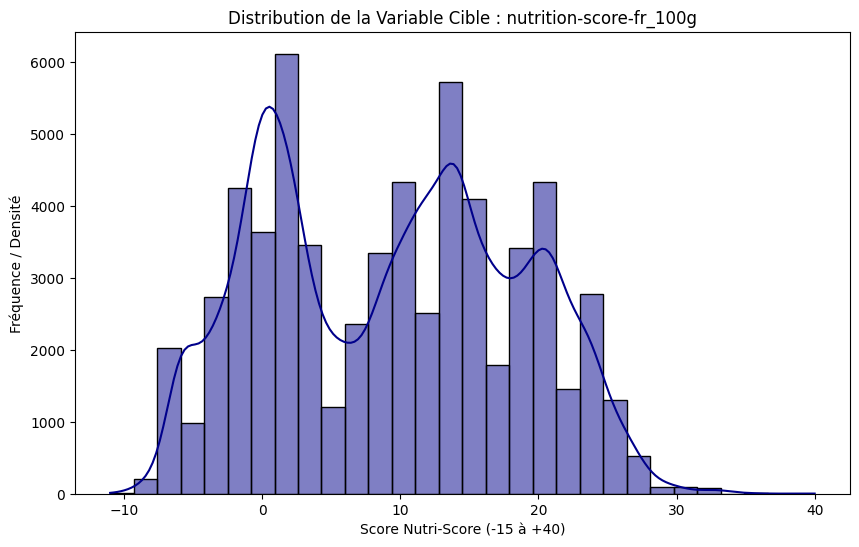

Score Nutri-Score moyen : 9.37
Score Nutri-Score médian : 10.00
Écart-type : 9.09


In [12]:
# Visualisation de la distribution de la variable cible (Score Nutri-Score)
plt.figure(figsize=(10, 6))
# Utilisation de Seaborn pour un histogramme de densité
sns.histplot(y_train, kde=True, bins=30, color='darkblue') 
plt.title(f"Distribution de la Variable Cible : {TARGET_COLUMN}")
plt.xlabel("Score Nutri-Score (-15 à +40)")
plt.ylabel("Fréquence / Densité")
plt.show()

# Calcul des statistiques (Module 02: Data Exploration)
print(f"Score Nutri-Score moyen : {y_train.mean():.2f}")
print(f"Score Nutri-Score médian : {y_train.median():.2f}")
print(f"Écart-type : {y_train.std():.2f}")

# Interprétation : Vérifier si la distribution est symétrique, si elle est 'tail-heavy' (asymétrique), 
# ou si des pics (outliers) apparaissent (qui pourraient nécessiter une transformation logarithmique, par exemple).

--- Corrélation de chaque feature avec le Nutri-Score Score (Cible) ---
nutrition-score-fr_100g        1.000000
saturated-fat_100g             0.669188
energy_100g                    0.625562
fat_100g                       0.580693
sugars_100g                    0.446554
carbohydrates_100g             0.224415
proteins_100g                  0.141996
salt_100g                      0.057868
sodium_100g                    0.057868
fiber_100g                    -0.200855
fruits-vegetables-nuts_100g   -0.500910
Name: nutrition-score-fr_100g, dtype: float64


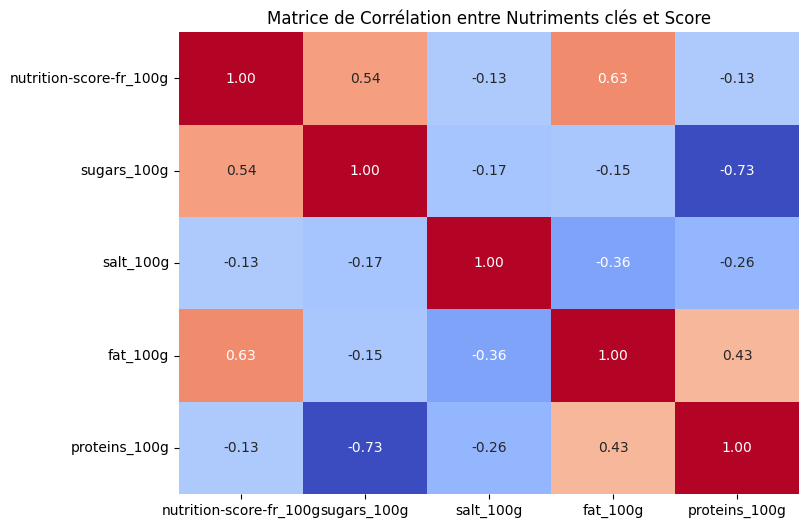

In [14]:
## Analyse de Corrélation (Module 02: Data Exploration - Correlations)

# Calculer la matrice de corrélation de Pearson
corr_matrix = eda_data.select_dtypes(include=np.number).corr()

print("--- Corrélation de chaque feature avec le Nutri-Score Score (Cible) ---")
print(corr_matrix[TARGET_COLUMN].sort_values(ascending=False))

# Visualisation des corrélations (Exemple: les plus corrélés)
plt.figure(figsize=(8, 6))
# Utilisation de la carte de chaleur (Heatmap) pour la corrélation
sns.heatmap(corr_matrix[[TARGET_COLUMN, 'sugars_100g', 'salt_100g', 'fat_100g', 'proteins_100g']].corr(), 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f",
            cbar=False)
plt.title("Matrice de Corrélation entre Nutriments clés et Score")
plt.show()

# Interprétation : 
# * Les nutriments qui augmentent le score (mauvais) ont une corrélation positive (ex: sucres, graisses saturées).
# * Les nutriments qui diminuent le score (bons) ont une corrélation négative (ex: fibres, protéines).


--- Exploration Non-Supervisée (K-Means Clustering) ---

Score Nutri-Score Médian par Cluster Non-Supervisé:
Cluster
0     2.0
4     8.0
1    18.0
2    19.0
3    19.0
Name: nutrition-score-fr_100g, dtype: float64


C:\Users\jeann\AppData\Local\Temp\ipykernel_6368\2128821494.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=median_score_per_cluster.index, y=median_score_per_cluster.values, palette='RdYlGn_r')


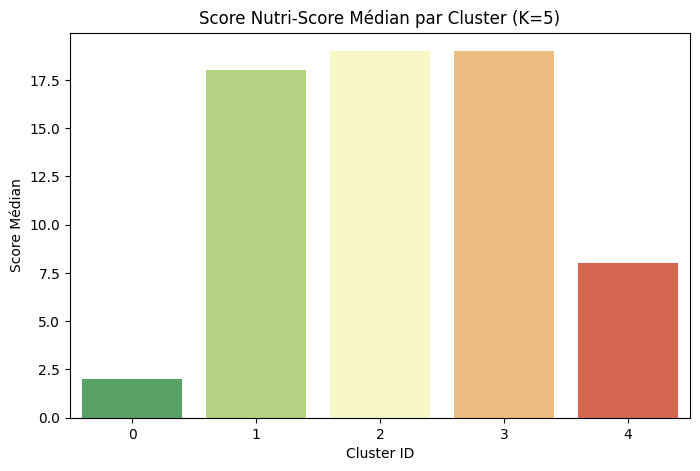

In [15]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

print("\n--- Exploration Non-Supervisée (K-Means Clustering) ---")

# 1. Préparation des données numériques pour le clustering (pas de labels)
X_num_train = X_train[numerical_features]

# Nettoyage et Mise à l'échelle (essentiel pour K-Means)
clustering_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),   # Gérer les NaN (Imputation par médiane)
    StandardScaler()                    # Mise à l'échelle (Standardisation) [cite: 4874]
)
X_num_scaled = clustering_pipeline.fit_transform(X_num_train)

# 2. Définir le nombre de clusters K (ex: K=5, correspondant aux 5 grades A-E)
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
X_train_clusters = kmeans.fit_predict(X_num_scaled)

# 3. Analyser la relation entre les clusters et la cible (Nutri-Score)
# Ajouter le cluster trouvé et le score réel au jeu de données d'entraînement
eda_data['Cluster'] = X_train_clusters
median_score_per_cluster = eda_data.groupby('Cluster')[TARGET_COLUMN].median().sort_values()

print("\nScore Nutri-Score Médian par Cluster Non-Supervisé:")
print(median_score_per_cluster)

# Visualisation (Optionnel mais recommandé pour la soumission)
plt.figure(figsize=(8, 5))
sns.barplot(x=median_score_per_cluster.index, y=median_score_per_cluster.values, palette='RdYlGn_r')
plt.title(f"Score Nutri-Score Médian par Cluster (K={k})")
plt.xlabel("Cluster ID")
plt.ylabel("Score Médian")
plt.show()

# Interprétation: Si le score médian augmente ou diminue de façon ordonnée avec les clusters, 
# cela valide la pertinence des caractéristiques choisies.